In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
from __future__ import division
import os
import re
import matplotlib
from collections import OrderedDict
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import pynocular as pn
import pickle
from scipy import stats
from retro.utils.stats import estimate_from_llhp
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import pandas
import math
from numba import jit
import feather
#import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.ensemble import *

/home/peller/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = [8., 6.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
use_xgb = True

In [4]:
date = '2019.02.20'
first = True
for mc in ['129002', '149002']:
    for dir in [str(d).zfill(6) for d in range(20)]:
        fname = '/data/peller/retro/recos/%s/oscNext/pass2/genie/level5/%s/oscNext_genie_level5_pass2.%s.%s/reconstructed_events.feather'%(date, mc, mc, dir)
        if not os.path.isfile(fname):
            continue
        else:
            print mc, dir
        if first:
            df = feather.read_dataframe(fname)
            first = False
        else:
            df = df.append(feather.read_dataframe(fname))

df = df.dropna(subset=['retro_energy'])

129002 000000
129002 000001
129002 000002
129002 000003
129002 000004
129002 000005
129002 000006
129002 000007
129002 000008
129002 000009
129002 000010
129002 000011
149002 000000
149002 000001
149002 000002
149002 000003
149002 000004
149002 000005
149002 000006
149002 000007
149002 000008
149002 000009
149002 000010
149002 000011


In [5]:
df['pid'] = np.logical_and(df['InteractionType'] == 1, np.abs(df['pdg']) == 14).astype(np.int32)
df['pid_label'] = 'cascade'
df['pid_label'][df['pid'] == 1] = 'track'

print 'Total of %s events with %s tracks'%(len(df), np.sum(df['pid']))

Total of 113766 events with 58660 tracks


/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#for c in df.columns: print c
#df['retro_max_llh']
#df[keys]
#df.pdg
#df.InteractionType

In [7]:
# #keys = ['retro_zero_llh', 'retro_zero_llh_lower_bound', 'retro_zero_llh_upper_bound', 'retro_zero_llh_width', 'retro_lower_llh', 'retro_upper_llh', 'retro_track_energy', 'pid_label']
# #keys = ['retro_zero_llh', 'retro_lower_llh', 'retro_upper_llh', 'retro_track_energy', 'pid_label']
# keys = ['retro_zero_llh', 'retro_zero_llh_lower_bound', 'retro_track_energy', 'retro_track_energy_lower_bound', 'retro_zenith_width', 'retro_azimuth_width'] + ['pid_label']


# sns.set(style="ticks", color_codes=True)
# pp = sns.pairplot(df[keys], hue="pid_label", diag_kind="kde", markers="o",  palette="Set2",
#     plot_kws=dict(s=1, linewidth=0),
#     diag_kws=dict(shade=True,cumulative=True))
# for ax in pp.diag_axes:
#     #ax.set_xscale('log')
#     ax.set_ylim((0.1,1))
#     #ax.set_yscale('log')
# sns.plt.savefig('pid_vars.png')

In [8]:
def ROC(mask, var, cut, greater, weights=None):
    '''
    generate ROC true positive and fals positive rates for
    a given mask vs. antmask discrimination given a variable
    and a cur on that variable. (greater is for left vs. right)
    '''
    if weights is None:
        weights = np.ones_like(var)
    P = np.sum(weights[mask])
    N = np.sum(weights[~mask])
    if greater:
        TP = np.sum(weights[np.logical_and(mask, var >= cut)])
        FP = np.sum(weights[np.logical_and(~mask, var >= cut)])
    else:
        TP = np.sum(weights[np.logical_and(mask, var < cut)])
        FP = np.sum(weights[np.logical_and(~mask, var < cut)])
    return [TP/P, FP/N]


def plot_roc(mask, var, label, cuts, greater=True, weights=None):
    if greater:
        points = [[1.,1.]]
    else:
        points = [[0.,0.]]
        
    for cut in cuts:
        points.append(ROC(mask, var, cut, greater, weights))
    if greater:
        points.append([0.,0.])
    else:
        points.append([1.,1.])
    points = np.array(points)
    a = auc(points[:,1], points[:,0])
    plt.plot(points[:,1], points[:,0], label=label + ' (area = %.3f)'%a)

# PID classifier

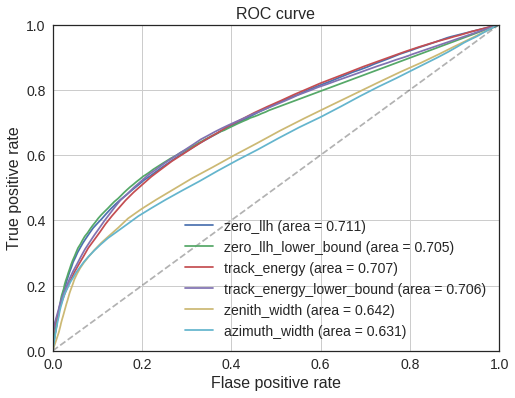

In [901]:
plot_roc(df['pid']==1, df['retro_zero_llh'], label='zero_llh' ,cuts=np.logspace(-1,3,100), weights=df['weight'])
plot_roc(df['pid']==1, df['retro_zero_llh_lower_bound'], label='zero_llh_lower_bound' ,cuts=np.logspace(-1,3,100), weights=df['weight'])
plot_roc(df['pid']==1, df['retro_track_energy'], label='track_energy' ,cuts=np.logspace(-1,3,100), weights=df['weight'])
plot_roc(df['pid']==1, df['retro_track_energy_lower_bound'], label='track_energy_lower_bound' ,cuts=np.logspace(-1,3,100), weights=df['weight'])
plot_roc(df['pid']==1, df['retro_zenith_width'], label='zenith_width' ,cuts=np.logspace(-2,2,100), greater=False, weights=df['weight'])
plot_roc(df['pid']==1, df['retro_azimuth_width'], label='azimuth_width' ,cuts=np.logspace(-2,2,100), greater=False, weights=df['weight'])
#plot_roc(df['pid']==1, df['retro_max_llh'], label='max llh' ,cuts=np.logspace(-1,3,100), weights=df['weight'])
#plot_roc(df['pid']==1, df['retro_zenith'], label='zen' ,cuts=np.logspace(-1,3,100), weights=df['weight'])


plt.gca().set_ylabel('True positive rate')
plt.gca().set_xlabel('Flase positive rate')
plt.gca().set_title('ROC curve')

plt.plot([0,1],[0,1], 'k--', alpha=0.3)
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)
plt.grid()
plt.legend()
plt.savefig('pid_roc.png')

In [902]:
keys = []
for c in df.columns:
    if 'retro' in c and not 'pft' in c:
        keys.append(c) 


In [986]:
#keys = ['retro_zero_llh', 'retro_zero_llh_lower_bound', 'retro_zero_llh_upper_bound', 'retro_zero_llh_width', 'retro_lower_llh', 'retro_upper_llh', 'retro_track_energy', 'retro_max_llh',
#        'retro_x', 'retro_y', 'retro_z', 'retro_zenith', 'retro_azimuth', 'retro_energy']
keys = ['retro_zero_llh', 'retro_zero_llh_lower_bound', 'retro_track_energy', 'retro_track_energy_lower_bound', 'retro_zenith_width', 'retro_azimuth_width', 'retro_upper_llh', 'retro_zero_llh_width']
#keys = ['retro_zero_llh', 'retro_track_energy', 'retro_zenith_width', 'retro_azimuth_width', 'retro_upper_llh']
#keys = ['retro_track_energy']
X = df[keys].values
Y = df['pid'].values
W = df['weight'].values
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.2, random_state=42)
if use_xgb:
    dtrain = xgb.DMatrix(x_train, y_train, feature_names=keys)
    dtest = xgb.DMatrix(x_test, y_test, feature_names=keys)
    D = xgb.DMatrix(X, feature_names=keys)

In [987]:
if not use_xgb:
    #clf = MLPClassifier(activation='tanh', hidden_layer_sizes=(100,), verbose=True, tol=0.000001,)
    clf = GradientBoostingClassifier(verbose=True, n_estimators=10, max_depth=5)
    #clf = RandomForestClassifier()
    clf.fit(x_train, y_train)

[0]	eval-error:0.345917	eval-auc:0.714057	train-error:0.34324	train-auc:0.714943
[1]	eval-error:0.344599	eval-auc:0.718261	train-error:0.341955	train-auc:0.718719
[2]	eval-error:0.344423	eval-auc:0.718757	train-error:0.341669	train-auc:0.719942
[3]	eval-error:0.344071	eval-auc:0.719583	train-error:0.341482	train-auc:0.720673
[4]	eval-error:0.343412	eval-auc:0.719608	train-error:0.341537	train-auc:0.721163
[5]	eval-error:0.343588	eval-auc:0.719708	train-error:0.341252	train-auc:0.72165
[6]	eval-error:0.3435	eval-auc:0.720021	train-error:0.340768	train-auc:0.721993
[7]	eval-error:0.344291	eval-auc:0.720427	train-error:0.341219	train-auc:0.72249
[8]	eval-error:0.343852	eval-auc:0.720529	train-error:0.340724	train-auc:0.72286
[9]	eval-error:0.343192	eval-auc:0.720863	train-error:0.340373	train-auc:0.723031
[10]	eval-error:0.343148	eval-auc:0.721104	train-error:0.340032	train-auc:0.723304
[11]	eval-error:0.343236	eval-auc:0.721264	train-error:0.33968	train-auc:0.723624
[12]	eval-error:0.342

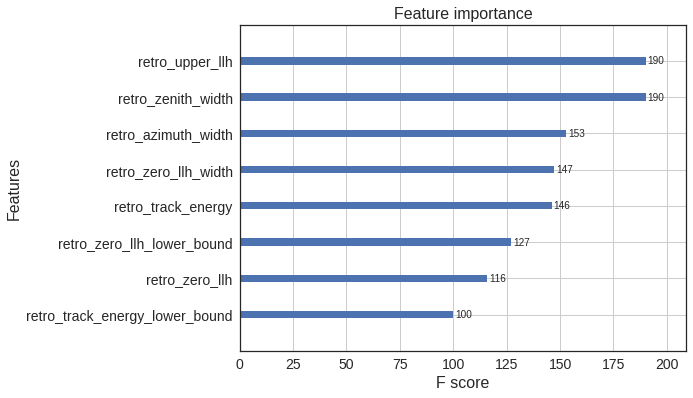

In [1034]:
if use_xgb:
    param = {'max_depth': 5, 'eta': 0.1, 'gamma':1, 'silent': 1, 'objective': 'binary:logistic'}
    param['nthread'] = 12
    param['eval_metric'] = ['error', 'auc']
    evallist = [(dtest, 'eval'), (dtrain, 'train')]

    num_round = 40
    bst = xgb.train(param, dtrain, num_round, evallist)
    
    xgb.plot_importance(bst,max_num_features=10, )

In [1035]:
if use_xgb:
    y_pred = bst.predict(dtest)
    y_pred_t = bst.predict(dtrain)
    df['classifier_pid'] = bst.predict(D)
else:
    y_pred = clf.predict_proba(x_test)[:,1]
    y_pred_t = clf.predict_proba(x_train)[:,1]
    df['classifier_pid'] = clf.predict_proba(X)[:,1]

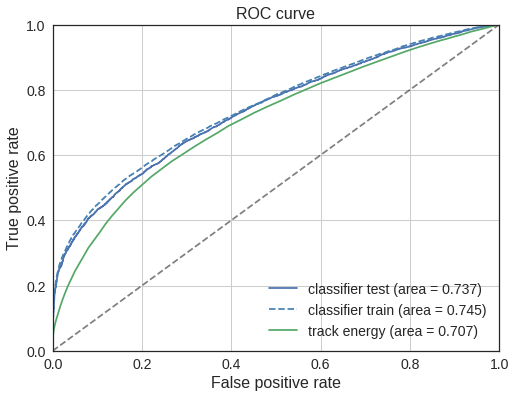

In [1036]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, sample_weight=w_test)
#sorted_idx = np.argsort(fpr)
#fpr = fpr[sorted_idx]
#tpr = tpr[sorted_idx]
area = auc(fpr, tpr, reorder=True)
fpr_t, tpr_t, thresholds_t = roc_curve(y_train, y_pred_t, sample_weight=w_train)
area_t = auc(fpr_t, tpr_t, reorder=True)
#plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.plot(fpr, tpr, label='classifier test (area = %.3f)'%(area))    
plt.plot(fpr_t, tpr_t, label='classifier train (area = %.3f)'%(area_t), ls='--', c='steelblue')    

plot_roc(df['pid']==1, df['retro_track_energy'], label='track energy' ,cuts=np.logspace(-1,3,100), weights=df['weight'])
#plot_roc(df['pid']==1, df['retro_zero_llh'], label='zero_llh' ,cuts=np.logspace(-1,3,100))


plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)
plt.grid()
plt.legend()
plt.savefig('pid_test.png')

In [18]:
def errors(sample, bins, weights):
    '''
    return histo, errors and norm
    '''
    h,_ = np.histogram(sample, bins=bins, weights=weights)
    v,_ = np.histogram(sample, bins=bins, weights=np.square(weights))
    n = np.sum(h)*(bins[-1] - bins[0])/(len(bins)-1.)
    return h, np.sqrt(v), n

def plot_train_test(train_predicted, train_true, test_predicted, test_true, train_weights, test_weights, label0, label1):
    bins=np.linspace(max(min(test_predicted), min(train_predicted)),min(max(test_predicted), max(train_predicted)),31)
    midpoints = 0.5*(bins[1:] + bins[:-1])
    #plt.hist(test_predicted[test_true==1], bins=bins, weights=test_weights[test_true==1] ,histtype='step', lw=2, hatch='////', color='darkred', label=label1+' test', density=True)
    #plt.hist(test_predicted[test_true==0], bins=bins, weights=test_weights[test_true==0], histtype='step', lw=2, hatch=r'\\\\', color='royalblue', label=label0+' test', density=True)

    h, e, n = errors(test_predicted[test_true==1], bins, test_weights[test_true==1])
    plt.errorbar(midpoints, h/n, yerr=e/n, fmt='o', color='royalblue', label=label1+' test')
    plt.hist(train_predicted[train_true==1], bins=bins, weights=train_weights[train_true==1] ,histtype='step', lw=2, hatch='////', color='royalblue', label=label1+' train', density=True)
    th, te, tn = errors(train_predicted[train_true==1], bins, train_weights[train_true==1])
    chi2_1 = np.sum(np.square(h/n - th/tn)/(np.square(e/n) + np.square(te/tn)))
    
    h, e, n = errors(test_predicted[test_true==0], bins, test_weights[test_true==0])
    plt.errorbar(midpoints, h/n, yerr=e/n, fmt='o', color='darkred', label=label0+' test')
    plt.hist(train_predicted[train_true==0], bins=bins, weights=train_weights[train_true==0], histtype='step', lw=2, hatch=r'\\\\', color='darkred', label=label0+' train', density=True)
    th, te, tn = errors(train_predicted[train_true==0], bins, train_weights[train_true==0])
    chi2_0 = np.sum(np.square(h/n - th/tn)/(np.square(e/n) + np.square(te/tn)))

    print "chi^2/d.o.f = %.2f (tracks), %.2f (cascades)"%(chi2_1/(len(midpoints)-1), chi2_0/(len(midpoints)-1))
    print 'p cascades: %.2f %%'%(100*(1-stats.chi2.cdf(chi2_0,len(midpoints)-1)))
    print 'p tracks: %.2f %%'%(100*(1-stats.chi2.cdf(chi2_1,len(midpoints)-1)))
    
    plt.legend(loc='best')
    plt.gca().set_xlabel('PID score')

chi^2/d.o.f = 1.14 (tracks), 0.92 (cascades)
p cascades: 58.28 %
p tracks: 27.68 %


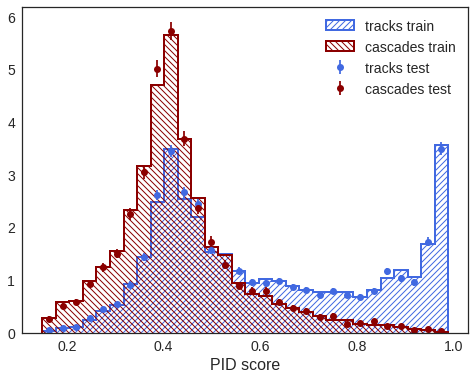

In [1044]:
plot_train_test(y_pred_t, y_train, y_pred, y_test, w_train, w_test, 'cascades', 'tracks')
plt.savefig('pid_score_test_sample.png')
#plt.gca().set_yscale('log')

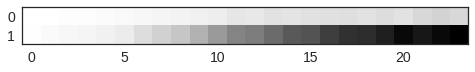

In [1039]:
e_bins = np.logspace(0.5,2.2,25)
e_midpoints = 0.5 * (e_bins[:-1] + e_bins[1:])

cut = 0.53

h = np.histogramdd([df['pid'], df['classifier_pid'], df['energy']], bins=[[0, 0.5, 1.],[0, cut, 1.], e_bins], weights=df['weight'])
h = h[0]
# normalize
h[0] /= np.sum(h[0])
h[1] /= np.sum(h[1])
track_fraction = h[:,1,:] / np.sum(h, axis=1)
cascade_fraction = h[:,0,:] / np.sum(h, axis=1)

#purity = 

htl = np.histogramdd([df['pid'], df['retro_track_energy'], df['energy']], bins=[[0, 0.5, 1.],[0, 11.1, 1e6], e_bins], weights=df['weight'])
htl = htl[0]
# normalize
htl[0] /= np.sum(htl[0])
htl[1] /= np.sum(htl[1])
track_fraction_tl = htl[:,1,:] / np.sum(htl, axis=1)
cascade_fraction_tl = htl[:,0,:] / np.sum(htl, axis=1)

plt.imshow(track_fraction)

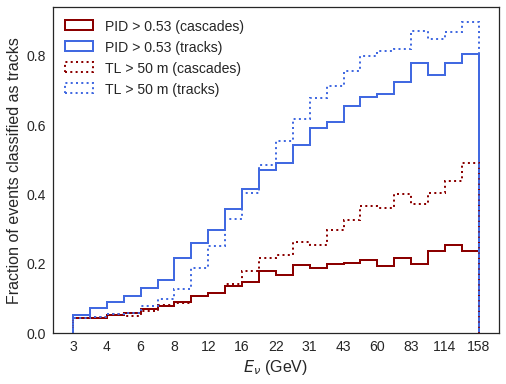

In [1040]:
plt.hist(e_midpoints, bins=e_bins, weights=track_fraction[0], histtype='step', lw=2, label='PID > %s (cascades)'%cut, color='darkred')
plt.hist(e_midpoints, bins=e_bins, weights=track_fraction[1], histtype='step', lw=2, label='PID > %s (tracks)'%cut, color='royalblue')
#plt.hist(e_midpoints, bins=e_bins, weights=cascade_fraction[0], histtype='step', lw=2, label='PID (tracks)', color='b')
plt.hist(e_midpoints, bins=e_bins, weights=track_fraction_tl[0], histtype='step', lw=2, label='TL > 50 m (cascades)', color='darkred', ls=':')
plt.hist(e_midpoints, bins=e_bins, weights=track_fraction_tl[1], histtype='step', lw=2, label='TL > 50 m (tracks)', color='royalblue', ls=':')
#plt.hist(e_midpoints, bins=e_bins, weights=cascade_fraction_tl[0], histtype='step', lw=2, label='TL (tracks)', color='b', ls='--')
#plt.hist(e_midpoints, bins=e_bins, weights=cascade_fraction[0], histtype='step', lw=2)
#plt.hist(e_midpoints, bins=e_bins, weights=cascade_fraction[1], histtype='step', lw=2)
plt.gca().set_xscale('log')
plt.legend(loc='upper left')
plt.gca().set_ylabel('Fraction of events classified as tracks')
plt.gca().set_xlabel(r'$E_\nu$ (GeV)')
plt.xticks(e_bins[::2])
plt.gca().set_xticklabels(['%.0f'% e for e in e_bins[::2]], fontsize=14)
plt.gca().get_xaxis().get_major_formatter().labelOnlyBase = False

In [485]:
np.exp(e_bins)

array([2.36243429e+01, 4.28786504e+01, 8.70807563e+01, 2.02116536e+02,
       5.49810374e+02, 1.80613069e+03, 7.42426806e+03, 3.98364361e+04,
       2.93388843e+05, 3.14824767e+06, 5.28407959e+07, 1.50926769e+09,
       8.10931487e+10, 9.23319436e+12, 2.56654986e+15, 2.06085031e+18,
       5.83828103e+21, 7.40079205e+25, 5.56794279e+30, 3.47797705e+36,
       2.68811714e+43])

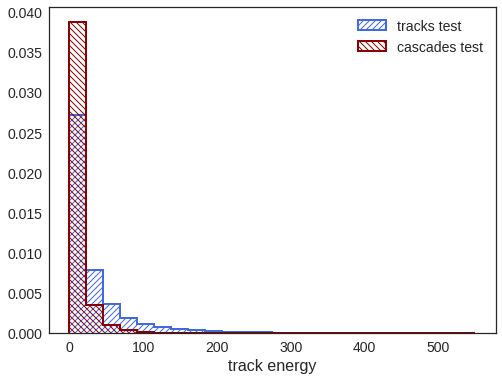

In [530]:
bins=np.linspace(min(df['retro_track_energy']),max(df['retro_track_energy']),25)
#bins=np.logspace(-1,3)

plt.hist(df['retro_track_energy'][df['pid'] == 1], bins=bins, weights=df['weight'][df['pid'] == 1] ,histtype='step', lw=2, hatch='////', color='royalblue', label='tracks test', density=True)
plt.hist(df['retro_track_energy'][df['pid'] == 0], bins=bins, weights=df['weight'][df['pid'] == 0] ,histtype='step', lw=2, hatch=r'\\\\', color='darkred', label='cascades test', density=True)

plt.legend()
plt.gca().set_xlabel('track energy')
#plt.gca().set_xscale('log')
plt.savefig('trk_test_sample.png')

# Energy regression

In [75]:
df['retro_coszen'] = np.cos(df['retro_zenith'])
df['zenith'] = np.arccos(df['coszen'])

In [580]:
keys = []
for c in df.columns:
    if 'retro' in c and not 'pft' in c and 'energy' in c:
        keys.append(c) 

In [581]:
keys

[u'retro_cascade_energy',
 u'retro_cascade_energy_lower_bound',
 u'retro_cascade_energy_upper_bound',
 u'retro_cascade_energy_width',
 u'retro_energy',
 u'retro_energy_lower_bound',
 u'retro_energy_upper_bound',
 u'retro_energy_width',
 u'retro_track_energy',
 u'retro_track_energy_lower_bound',
 u'retro_track_energy_upper_bound',
 u'retro_track_energy_width']

In [651]:
target='energy'

#keys = ['retro_zero_llh', 'retro_zero_llh_lower_bound', 'retro_zero_llh_upper_bound', 'retro_zero_llh_width', 'retro_lower_llh', 'retro_upper_llh', 'retro_track_energy', 'retro_max_llh',
#        'retro_x', 'retro_y', 'retro_z', 'retro_zenith', 'retro_azimuth', 'retro_energy']
#keys = ['retro_zero_llh', 'retro_zero_llh_lower_bound', 'retro_track_energy', 'retro_track_energy_lower_bound', 'retro_zenith_width', 'retro_azimuth_width']
#keys = ['retro_track_energy']
#keys += ['retro_zenith', 'retro_azimuth', 'retro_x', 'retro_y', 'retro_z']
X = df[keys].values
X = np.log(X)
X[X < -1e9] = -1e9
Y = df[target].values
Y = np.log(Y)
W = df['weight'].values
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.2, random_state=42)
if use_xgb:
    dtrain = xgb.DMatrix(x_train, y_train, feature_names=keys)
    dtest = xgb.DMatrix(x_test, y_test, feature_names=keys)
    D = xgb.DMatrix(X, feature_names=keys)

/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [652]:
np.min(X)

-1000000000.0

In [890]:
if not use_xgb:

    #reg = MLPRegressor(verbose=True, hidden_layer_sizes=(20,5), activation='tanh', learning_rate='adaptive', solver='adam')
    #reg = svm.SVR(kernel='poly', verbose=True)
    reg = GradientBoostingRegressor(verbose=True, loss='ls', n_estimators=500, max_depth=2, min_samples_leaf=1000)
    #reg = AdaBoostRegressor(loss='square')
    #reg = BaggingRegressor(GradientBoostingRegressor(min_samples_leaf=100, max_depth=3, n_estimators=100), verbose=True, bootstrap_features=True, n_jobs=-1)

    reg.fit(x_train, y_train)#, w_train)

    y_pred = np.exp(reg.predict(x_test))
    y_pred_t = np.exp(reg.predict(x_train))
    df['regressed_energy'] = np.exp(reg.predict(X))

      Iter       Train Loss   Remaining Time 
         1           1.3224           43.27s
         2           1.1651           41.61s
         3           1.0346           40.98s
         4           0.9274           40.70s
         5           0.8373           40.45s
         6           0.7634           40.33s
         7           0.7007           40.11s
         8           0.6475           39.29s
         9           0.6038           38.47s
        10           0.5656           37.54s
        20           0.3980           32.92s
        30           0.3644           30.98s
        40           0.3565           29.56s
        50           0.3539           28.25s
        60           0.3526           27.23s
        70           0.3516           26.19s
        80           0.3509           25.41s
        90           0.3504           24.59s
       100           0.3499           23.81s
       200           0.3477           17.05s
       300           0.3465           11.37s
       40

In [891]:
for k,v in zip(keys, reg.feature_importances_):
    print k, '%.3f'%v

retro_cascade_energy 0.115
retro_cascade_energy_lower_bound 0.042
retro_cascade_energy_upper_bound 0.092
retro_cascade_energy_width 0.162
retro_energy 0.073
retro_energy_lower_bound 0.163
retro_energy_upper_bound 0.048
retro_energy_width 0.099
retro_track_energy 0.032
retro_track_energy_lower_bound 0.047
retro_track_energy_upper_bound 0.060
retro_track_energy_width 0.066


In [892]:
if use_xgb:

    param = {'max_depth': 9, 'eta': 0.05, 'gamma':10, 'silent': 1, 'objective': 'reg:linear'}
    param['nthread'] = 12
    param['eval_metric'] = ['rmse']
    evallist = [(dtest, 'eval'), (dtrain, 'train')]

    num_round = 10
    bst = xgb.train(param, dtrain, num_round, evallist)

    y_pred = np.exp(bst.predict(dtest))
    y_pred_t = np.exp(bst.predict(dtrain))
    df['regressed_energy'] = np.exp(bst.predict(D))
    
    xgb.plot_importance(bst,max_num_features=10, )

IQ50 test: 13.59
IQ50 train: 13.57
IQ50 retro: 19.46


(0, 0.07)

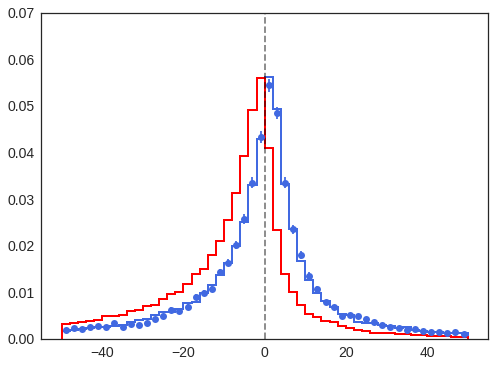

In [893]:
bins=np.linspace(-50,50,51)
midpoints = 0.5*(bins[1:] + bins[:-1])


error_test = y_pred-np.exp(y_test)
error_train = y_pred_t-np.exp(y_train)
error_retro = df['retro_'+target] - df[target]

h,e,n = errors(error_test, bins=bins, weights=w_test)
#plt.bar(midpoints, h/n, width=np.diff(bins), lw=2, alpha=0)
plt.errorbar(midpoints, h/n, yerr=e/n, fmt='o', color='royalblue', label='test')


#plt.hist(error_test, bins=bins, histtype='step', density=True, lw=2, weights=w_test)
plt.hist(error_train, bins=bins, histtype='step', density=True, lw=2, weights=w_train, color='royalblue',);

plt.hist(error_retro, bins=bins, histtype='step', density=True, lw=2, weights=df['weight'], color='red');

print'IQ50 test: %.2f'%(np.percentile(error_test, q=75) - np.percentile(error_test, q=25))
print'IQ50 train: %.2f'%(np.percentile(error_train, q=75) - np.percentile(error_train, q=25))
print'IQ50 retro: %.2f'%(np.percentile(error_retro, q=75) - np.percentile(error_retro, q=25))

plt.gca().vlines(0,0,0.07, linestyle='--', alpha=0.5)
plt.gca().set_ylim((0,0.07))

#fit = stats.cauchy.fit(error_retro)
#plt.plot(bins, fun.pdf(bins, *fit) * np.average(np.diff(bins)))
#ax2.plot(x,p, color=color)

#plt.gca().set_yscale('log')

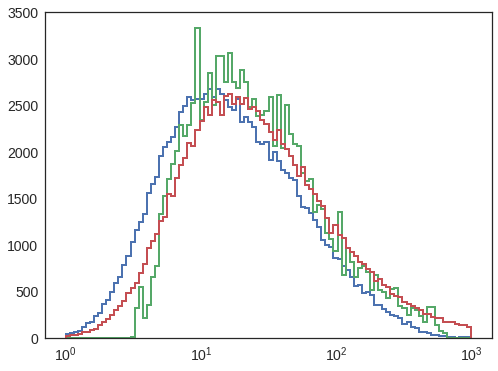

In [894]:
var='energy'
#bins=np.linspace(9000,10000,31)
bins=np.logspace(0,3,101)
plt.hist(df['retro_'+var], bins=bins, histtype='step', lw=2);
plt.hist(df['regressed_'+var], bins=bins, histtype='step', lw=2);
plt.hist(df[var], bins=bins, histtype='step', lw=2);
plt.gca().set_xscale('log')

In [ ]:
np.exp(np.log(10))

5.029977299902692
40.89061046333007


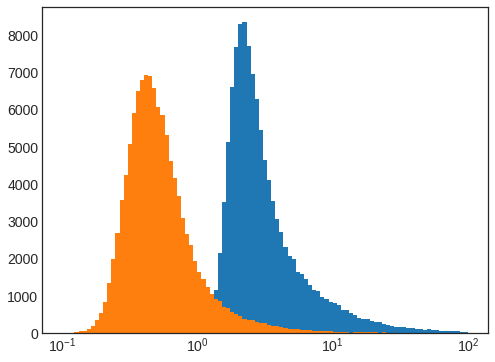

In [101]:
plt.hist((df['retro_run_time']+df['retro_pft_run_time'])/60, bins=np.logspace(-1,2,100))
plt.hist((df['retro_pft_run_time'])/60, bins=np.logspace(-1,2,100))
plt.gca().set_xscale('log')

print np.average(df['retro_run_time']+df['retro_pft_run_time'])/60

print np.average(df['retro_pft_run_time'])


# Symbolic regression

In [9]:
from gplearn.genetic import SymbolicRegressor

In [11]:
reg_keys = []
for c in df.columns:
    if 'retro' in c and not 'pft' in c and 'energy' in c:
        reg_keys.append(c) 

X = df[reg_keys].values
Y = df['energy'].values
W = df['weight'].values
x_train_reg, x_test_reg, y_train_reg, y_test_reg, w_train_reg, w_test_reg = train_test_split(X, Y, W, test_size=0.2, random_state=42)

In [61]:
est_gp = SymbolicRegressor(population_size=500,
                           generations=50, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                           function_set=('add', 'sub', 'mul', 'div', 'sqrt'),# 'abs', 'neg', 'inv'),
                           metric='mean absolute error')
est_gp.fit(x_train_reg, y_train_reg)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.68 504907674683583.06        3 24.915054019725257 24.42722011941019      4.53m
   1      7.6 1601714245.413799        8 24.666372717162496 24.93192727806731      3.34m
   2     4.91 586.7356197146119        8 24.617323213390357 25.373329701048622      2.74m
   3     4.27 4112905.1667145044        8 24.534415090358884 26.11942993808533      2.40m
   4     4.87 74465.02420012212        8 24.501085857431878 26.419363740442066      2.21m
   5     6.51 45.83115377526454        8 24.518962180134118 26.25849254811725      2.08m
   6     7.88 526.4546771099344        8 24.438993696866646 26.97813861100876      2.01m
   7     7.66 40.470939327796145        6 24.386355131439792 25.15546145726475      1.93m
   8     7.15 59.47030353668699       

SymbolicRegressor(const_range=(-1.0, 1.0),
         function_set=('add', 'sub', 'mul', 'div', 'sqrt'), generations=50,
         init_depth=(2, 6), init_method='half and half', max_samples=0.9,
         metric='mean absolute error', n_jobs=1, p_crossover=0.7,
         p_hoist_mutation=0.05, p_point_mutation=0.1, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.01,
         population_size=500, random_state=0, stopping_criteria=0.01,
         tournament_size=20, verbose=1, warm_start=False)

In [62]:
print est_gp._program
y_pred_reg = est_gp.predict(x_test_reg)
y_pred_t_reg = est_gp.predict(x_train_reg)
df['regressed_energy'] = est_gp.predict(X)
for i,k in enumerate(reg_keys):
    print 'X%i: %s'%(i,k)

add(add(sqrt(X10), X5), X1)
X0: retro_cascade_energy
X1: retro_cascade_energy_lower_bound
X2: retro_cascade_energy_upper_bound
X3: retro_cascade_energy_width
X4: retro_energy
X5: retro_energy_lower_bound
X6: retro_energy_upper_bound
X7: retro_energy_width
X8: retro_track_energy
X9: retro_track_energy_lower_bound
X10: retro_track_energy_upper_bound
X11: retro_track_energy_width


IQ50 test: 13.50
IQ50 train: 13.70
IQ50 retro: 19.57


(0, 0.06)

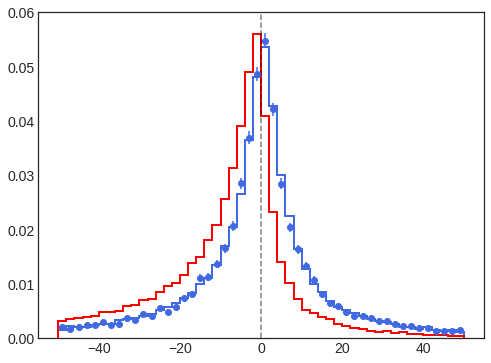

In [73]:
bins=np.linspace(-50,50,51)
midpoints = 0.5*(bins[1:] + bins[:-1])

error_test = y_pred_reg-y_test_reg
error_train = y_pred_t_reg-y_train_reg
error_retro = df['retro_energy'] - df['energy']

h,e,n = errors(error_test, bins=bins, weights=w_test_reg)
#plt.bar(midpoints, h/n, width=np.diff(bins), lw=2, alpha=0)
plt.errorbar(midpoints, h/n, yerr=e/n, fmt='o', color='royalblue', label='test')


#plt.hist(error_test, bins=bins, histtype='step', density=True, lw=2, weights=w_test)
plt.hist(error_train, bins=bins, histtype='step', density=True, lw=2, weights=w_train_reg, color='royalblue',);

plt.hist(error_retro, bins=bins, histtype='step', density=True, lw=2, weights=df['weight'], color='red');

print'IQ50 test: %.2f'%(np.percentile(error_test, q=75) - np.percentile(error_test, q=25))
print'IQ50 train: %.2f'%(np.percentile(error_train, q=75) - np.percentile(error_train, q=25))
print'IQ50 retro: %.2f'%(np.percentile(error_retro, q=75) - np.percentile(error_retro, q=25))

plt.gca().vlines(0,0,0.07, linestyle='--', alpha=0.5)
plt.gca().set_ylim((0,0.06))

#fit = stats.cauchy.fit(error_retro)
#plt.plot(bins, fun.pdf(bins, *fit) * np.average(np.diff(bins)))
#ax2.plot(x,p, color=color)

#plt.gca().set_yscale('log')

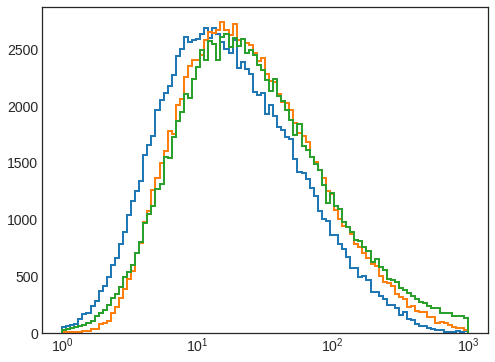

In [64]:
var='energy'
#bins=np.linspace(9000,10000,31)
bins=np.logspace(0,3,101)
plt.hist(df['retro_'+var], bins=bins, histtype='step', lw=2);
plt.hist(df['regressed_'+var], bins=bins, histtype='step', lw=2);
plt.hist(df[var], bins=bins, histtype='step', lw=2);
plt.gca().set_xscale('log')

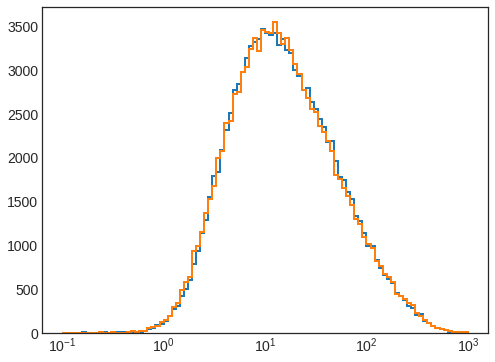

In [171]:
bins=np.logspace(-1,3,101)
var = 'energy_lower_bound'
plt.hist(df['retro_'+var], bins=bins, histtype='step', lw=2);
plt.hist(df['retro_pft_'+var], bins=bins, histtype='step', lw=2);
#plt.hist(df[var], bins=bins, histtype='step', lw=2, color='r');
#plt.hist(df[var], bins=bins, histtype='step', lw=2);
plt.gca().set_xscale('log')

In [141]:
df['retro_pft_zero_llh']

0         1.755454
1         0.366655
2        21.457357
3         4.340374
4         0.981912
5         1.389957
6         0.219542
7         5.769770
8         0.210831
9        17.200537
10        7.998849
11       55.165863
12        1.012307
13       21.689238
14        1.472836
15        4.987039
16        3.288025
17       91.742805
18        0.662389
19        0.015572
20      205.225952
21        1.420600
22       42.737839
23       23.087456
24        1.801226
25       42.793293
26        0.640063
27      273.943695
28       15.186705
29        2.454290
           ...    
6261     19.246180
6262      4.409237
6263      8.993361
6264     25.784853
6265      3.422140
6266     11.701121
6267      0.983006
6268      0.259803
6269     24.947674
6270     50.332619
6271     17.787554
6272      1.876002
6273      5.255145
6274     38.717308
6275     42.269035
6276      6.054704
6277      3.947503
6278    698.313721
6279     21.191652
6280      2.311846
6281      9.374736
6282      2.

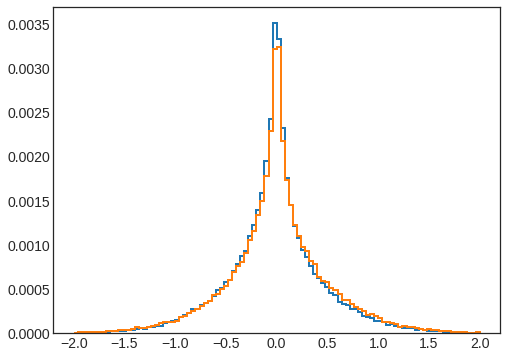

In [128]:
bins=np.linspace(-2,2,101)
var = 'zenith'
plt.hist(df['retro_'+var] - df[var], bins=bins, histtype='step', lw=2, weights=df['weight']);
plt.hist(df['retro_pft_'+var] - df[var], bins=bins, histtype='step', lw=2, weights=df['weight']);
#plt.gca().set_yscale('log')

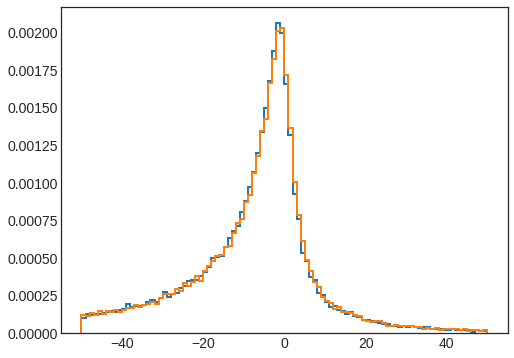

In [125]:
bins=np.linspace(-50,50,101)
var = 'energy'
plt.hist(df['retro_'+var] - df[var], bins=bins, histtype='step', lw=2, weights=df['weight']);
plt.hist(df['retro_pft_'+var] - df[var], bins=bins, histtype='step', lw=2, weights=df['weight']);
#plt.gca().set_yscale('log')

In [106]:
np.average(df['retro_pft_num_llh'])

4136.577782465763

In [107]:
np.average(df[''])

12569.825712427262

(array([1.1000e+01, 5.2710e+04, 1.5249e+04, 4.5796e+04, 0.0000e+00]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

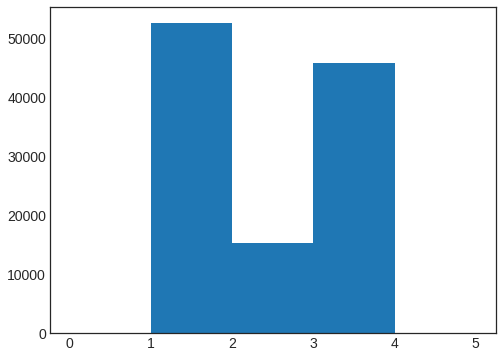

In [112]:
plt.hist(df['retro_pft_stopping_flag'], bins=np.arange(6))